**ML-Driven Framework for Multi-Step Cloud Attack Detection Using Synthetic Log Data**

Train and evaluate detectors that distinguish normal vs anomalous cloud activity using supervised and anomaly-detection approaches. Baselines will include rule-based heuristics, IsolationForest (unsupervised), and supervised classifiers (RandomForest / XGBoost).

In [2]:
!pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from faker import Faker
import random
from datetime import datetime, timedelta
import ipaddress

fake = Faker()
Faker.seed(42)
random.seed(42)
np.random.seed(42)

REGIONS = ['us-east-1', 'us-west-2', 'ap-south-1', 'eu-west-1']
ACTIONS = ['login', 'list_buckets', 'get_object', 'put_object', 'delete_object',
           'launch_instance', 'terminate_instance', 'stop_instance', 'start_instance', 'access_db']
AUTH_METHODS = ['password', 'access_key', 'mfa']
USER_ROLES = ['admin', 'devops', 'developer', 'analytics', 'readonly']

region_country_coords = {
    'us-east-1': {'country':'US','lat':38.9,'long':-77.0},
    'us-west-2': {'country':'US','lat':37.7,'long':-122.4},
    'ap-south-1': {'country':'IN','lat':19.0,'long':72.8},
    'eu-west-1': {'country':'IE','lat':53.3,'long':-6.2}
}


action_stats = {
    'login': {'bytes_mean': 40, 'bytes_std': 15, 'latency_mean': 130, 'latency_std': 40},
    'list_buckets': {'bytes_mean': 250, 'bytes_std': 100, 'latency_mean': 80, 'latency_std': 25},
    'get_object': {'bytes_mean': 20000, 'bytes_std': 5000, 'latency_mean': 200, 'latency_std': 60},
    'put_object': {'bytes_mean': 5000, 'bytes_std': 2500, 'latency_mean': 200, 'latency_std': 60},
    'delete_object': {'bytes_mean': 1200, 'bytes_std': 400, 'latency_mean': 110, 'latency_std': 30}
}

def correlated_event(action):
    stats = action_stats.get(action, {'bytes_mean':1000,'bytes_std':500,'latency_mean':150,'latency_std':50})
    bytes_sent = max(0, int(np.random.normal(stats['bytes_mean'], stats['bytes_std'])))
    latency = max(5, int(np.random.normal(stats['latency_mean'], stats['latency_std'])))
    return bytes_sent, latency

def random_ip_by_region(region, public=False):
    if not public:

        return f"10.{random.randint(0,255)}.{random.randint(0,255)}.{random.randint(1,254)}"
    base = {
        'us-east-1': '18.0.0.0',
        'us-west-2': '52.0.0.0',
        'ap-south-1': '13.0.0.0',
        'eu-west-1': '35.0.0.0'
    }[region]
    base_int = int(ipaddress.IPv4Address(base))
    ip_int = base_int + random.randint(1, 50000)
    return str(ipaddress.IPv4Address(ip_int))

def geo_from_region(region, attack=False):
    base = region_country_coords[region]
    if attack and random.random() < 0.4:
        foreign = random.choice([v for k,v in region_country_coords.items() if k != region])
        return foreign['country'], foreign['lat'], foreign['long']
    return base['country'], base['lat'], base['long']

def generate_user_profiles(n):
    users=[]
    for i in range(1,n+1):
        role = random.choices(USER_ROLES, weights=[0.06,0.12,0.5,0.18,0.14])[0]
        home_region = random.choice(REGIONS)
        is_service = (random.random() < 0.08)
        users.append({'user_id':f"user_{i}", 'role':role, 'home_region':home_region, 'is_service_account':is_service})
    return users

region_active_hours = {
    'us-east-1': list(range(8,19)),
    'us-west-2': list(range(7,18)),
    'ap-south-1': list(range(9,22)),
    'eu-west-1': list(range(8,18))
}

def generate_timestamp(region, days_back=3, attack=False):
    if attack:
        hour = random.choice(list(range(0,6)) + list(range(20,24)))
    else:
        hour = random.choice(region_active_hours.get(region, list(range(0,24))))
    minute = random.randint(0,59)
    second = random.randint(0,59)
    return (datetime.now() - timedelta(days=random.randint(0,days_back))).replace(
        hour=hour, minute=minute, second=second)

def generate_session_events(user, start_ts, session_id, session_len=5):
    events=[]
    region = user['home_region']

    for i in range(session_len):
        ts = generate_timestamp(region, days_back=7)

        action = random.choices(ACTIONS, weights=[0.18,0.05,0.18,0.15,0.02,0.07,0.05,0.06,0.06,0.18])[0]
        source_ip = random_ip_by_region(region, public=(random.random()<0.05))

        status = random.choices(['success','fail'], weights=[0.95,0.05])[0]

        # Normal behavior = small bytes, realistic latency
        bytes_sent, latency = correlated_event(action)
        bytes_received = int(bytes_sent * np.random.uniform(0.5, 0.9))

        country, lat, long = geo_from_region(region, attack=False)
        ip = source_ip

        ip_is_public = not ip.startswith("10.")
        asn = random.choice([13335, 16509, 14618, 8075])  # Cloudflare, AWS, Amazon, Microsoft
        vpc_id = f"vpc-{random.randint(10000,99999)}"
        subnet_id = f"subnet-{random.randint(10000,99999)}"
        src_port = random.randint(1024, 65535)
        dst_port = 443 if "object" in action or action=="login" else 80
        protocol = "TCP"
        events.append({
            'timestamp': ts,
            'user_id': user['user_id'],
            'session_id': session_id,
            'user_role': user['role'],
            'source_ip': source_ip,
            'region': region,
            'country': country,
            'latitude': lat,
            'longitude': long,
            'action': action,
            'status': status,
            'bytes_sent': bytes_sent,
            'bytes_received': bytes_received,
            'auth_method': random.choice(AUTH_METHODS),
            'response_time_ms': latency,
            'anomaly_label': 0,
            'ip_is_public': ip_is_public,
            'asn': asn,
            'vpc_id': vpc_id,
            'subnet_id': subnet_id,
            'src_port': src_port,
            'dst_port': dst_port,
            'protocol': protocol,
            'attack_type': None,
            'attack_stage': None

        })

    for ev in events:
        ev['attack_id'] = None
        ev['session_label'] = 0
        ev['ground_truth'] = 1

    return events

def attack_ip(region, attack_type):

    if attack_type in ['brute_force', 'credential_theft', 'api_abuse']:
        return random_ip_by_region(region, public=True)
    else:
        return random_ip_by_region(region, public=False)


def inject_attack(events, attack_type, users, instances=3):

    for _ in range(instances):

        if attack_type == 'brute_force':
            victim = random.choice([u for u in users if not u['is_service_account']])


            base_ts = generate_timestamp(victim['home_region'], days_back=2, attack=True)

            attacker_ip = attack_ip(victim['home_region'], 'brute_force')


            country, lat, long = geo_from_region(victim['home_region'], attack=True)

            session = f"atk_bf_{random.randint(10000,99999)}"

            for i in range(12):

                bytes_sent = random.randint(0, 20)
                latency = random.randint(300, 800)
                ip = attacker_ip

                ip_is_public = not ip.startswith("10.")
                asn = random.choice([13335, 16509, 14618, 8075])  # Cloudflare, AWS, Amazon, Microsoft
                vpc_id = f"vpc-{random.randint(10000,99999)}"
                subnet_id = f"subnet-{random.randint(10000,99999)}"
                src_port = random.randint(1024, 65535)
                dst_port = 443
                protocol = "TCP"

                events.append({
                    'timestamp': base_ts + timedelta(seconds=i*4),
                    'user_id': victim['user_id'],
                    'session_id': session,
                    'user_role': victim['role'],
                    'source_ip': attacker_ip,
                    'region': victim['home_region'],
                    'country': country,
                    'latitude': lat,
                    'longitude': long,
                    'action': 'login',
                    'status': 'fail' if i < 11 else 'success',
                    'bytes_sent': bytes_sent,
                    'bytes_received': 0,
                    'auth_method': 'password',
                    'response_time_ms':  int(latency + random.randint(50,150)),
                    'anomaly_label': 1,
                    'ip_is_public': ip_is_public,
                    'asn': asn,
                    'vpc_id': vpc_id,
                    'subnet_id': subnet_id,
                    'src_port': src_port,
                    'dst_port': dst_port,
                    'protocol': protocol,
                    'attack_type': 'brute_force',
                    'attack_stage': 'initial_access'
                })


        elif attack_type == 'credential_theft':
            victim = random.choice([u for u in users if not u['is_service_account']])
            foreign_region = random.choice([r for r in REGIONS if r != victim['home_region']])
            base_ts = generate_timestamp(foreign_region, days_back=3, attack=True)

            attacker_ip = attack_ip(foreign_region, 'credential_theft')
            country, lat, long = geo_from_region(foreign_region, attack=True)
            session = f"atk_ct_{random.randint(10000,99999)}"


            bytes_sent, latency = correlated_event('login')
            latency = max(20, int(np.random.normal(60, 15)))
            ip = attacker_ip

            ip_is_public = not ip.startswith("10.")
            asn = random.choice([13335, 16509, 14618, 8075])  # Cloudflare, AWS, Amazon, Microsoft
            vpc_id = f"vpc-{random.randint(10000,99999)}"
            subnet_id = f"subnet-{random.randint(10000,99999)}"
            src_port = random.randint(1024, 65535)
            dst_port = 443
            protocol = "TCP"
            events.append({
                'timestamp': base_ts,
                'user_id': victim['user_id'],
                'session_id': session,
                'user_role': victim['role'],
                'source_ip': attacker_ip,
                'region': foreign_region,
                'country': country,
                'latitude': lat,
                'longitude': long,
                'action': 'login',
                'status': 'success',
                'bytes_sent': int(bytes_sent * 0.1),
                'bytes_received': 0,
                'auth_method': 'access_key',
                'response_time_ms': random.randint(20,60),
                'anomaly_label': 1,
                'ip_is_public': ip_is_public,
                'asn': asn,
                'vpc_id': vpc_id,
                'subnet_id': subnet_id,
                'src_port': src_port,
                'dst_port': dst_port,
                'protocol': protocol,
                'attack_type': 'credential_theft',
                'attack_stage': 'initial_access'


            })


            for i, size in enumerate([random.randint(800000, 3000000), random.randint(10000, 50000)]):
                _, latency_g = correlated_event('get_object')
                latency_g = int(max(latency_g, 120))
                ip = attacker_ip

                ip_is_public = not ip.startswith("10.")
                asn = random.choice([13335, 16509, 14618, 8075])  # Cloudflare, AWS, Amazon, Microsoft
                vpc_id = f"vpc-{random.randint(10000,99999)}"
                subnet_id = f"subnet-{random.randint(10000,99999)}"
                src_port = random.randint(1024, 65535)
                dst_port = 443
                protocol = "TCP"
                events.append({
                    'timestamp': base_ts + timedelta(seconds=30 + i*10),
                    'user_id': victim['user_id'],
                    'session_id': session,
                    'user_role': victim['role'],
                    'source_ip': attacker_ip,
                    'region': foreign_region,
                    'country': country,
                    'latitude': lat,
                    'longitude': long,
                    'action': 'get_object',
                    'status': 'success',
                    'bytes_sent': int(size),
                    'bytes_received': 0,
                    'auth_method': 'access_key',
                    'response_time_ms': int(latency_g + random.randint(80,200)),
                    'anomaly_label': 1,
                    'attack_type': 'credential_theft',
                    'attack_stage': 'exfiltration'
                })

        elif attack_type == 'data_exfil':
            victim = random.choice(users)
            base_ts = generate_timestamp(victim['home_region'], days_back=7, attack=True)

            attacker_ip = attack_ip(victim['home_region'], 'data_exfil')
            country, lat, long = geo_from_region(victim['home_region'], attack=True)

            for i in range(4):
                _, latency_g = correlated_event('get_object')
                size = random.randint(500000, 5000000)
                latency_g = int(max(latency_g, 150))
                ip = attacker_ip

                ip_is_public = not ip.startswith("10.")
                asn = random.choice([13335, 16509, 14618, 8075])  # Cloudflare, AWS, Amazon, Microsoft
                vpc_id = f"vpc-{random.randint(10000,99999)}"
                subnet_id = f"subnet-{random.randint(10000,99999)}"
                src_port = random.randint(1024, 65535)
                dst_port = 443
                protocol = "TCP"
                events.append({
                    'timestamp': base_ts + timedelta(minutes=i*6),
                    'user_id': victim['user_id'],
                    'session_id': f"atk_exf_big_{random.randint(10000,99999)}",
                    'user_role': victim['role'],
                    'source_ip': attacker_ip,
                    'region': victim['home_region'],
                    'country': country,
                    'latitude': lat,
                    'longitude': long,
                    'action': 'get_object',
                    'status': 'success',
                    'bytes_sent': size,
                    'bytes_received': 0,
                    'auth_method': 'access_key',
                    'response_time_ms':int(latency_g + random.randint(150,300)),
                    'anomaly_label': 1,
                    'ip_is_public': ip_is_public,
                    'asn': asn,
                    'vpc_id': vpc_id,
                    'subnet_id': subnet_id,
                    'src_port': src_port,
                    'dst_port': dst_port,
                    'protocol': protocol,
                    'attack_type': 'data_exfil',
                    'attack_stage': 'exfiltration'
                })

            # Slow exfil pattern
            start = base_ts + timedelta(hours=2)
            for i in range(80):
                small_bs = int(abs(np.random.normal(20000, 8000)))
                _, latency_g = correlated_event('get_object')
                latency_g = int(max(latency_g, 80))
                ip = attacker_ip
                ip_is_public = not ip.startswith("10.")
                asn = random.choice([13335, 16509, 14618, 8075])  # Cloudflare, AWS, Amazon, Microsoft
                vpc_id = f"vpc-{random.randint(10000,99999)}"
                subnet_id = f"subnet-{random.randint(10000,99999)}"
                src_port = random.randint(1024, 65535)
                dst_port = 443
                protocol = "TCP"


                events.append({
                    'timestamp': start + timedelta(minutes=i*10),
                    'user_id': victim['user_id'],
                    'session_id': f"atk_exf_slow_{random.randint(10000,99999)}",
                    'user_role': victim['role'],
                    'source_ip': attacker_ip,
                    'region': victim['home_region'],
                    'country': country,
                    'latitude': lat,
                    'longitude': long,
                    'action': 'get_object',
                    'status': 'success',
                    'bytes_sent': small_bs,
                    'bytes_received': 0,
                    'auth_method': 'access_key',
                    'response_time_ms':int(latency_g + random.randint(30,80)),
                    'anomaly_label': 1,
                    'ip_is_public': ip_is_public,
                    'asn': asn,
                    'vpc_id': vpc_id,
                    'subnet_id': subnet_id,
                    'src_port': src_port,
                    'dst_port': dst_port,
                    'protocol': protocol,
                    'attack_type': 'data_exfil',
                    'attack_stage': 'exfiltration'
                })

        elif attack_type == 'privilege_misuse':
            low_user = random.choice([u for u in users if u['role'] in ('developer','readonly')])
            base_ts = generate_timestamp(low_user['home_region'], days_back=3, attack=True)
            attacker_ip = attack_ip(low_user['home_region'], 'privilege_misuse')
            country, lat, long = geo_from_region(low_user['home_region'], attack=False)


            for j in range(2):
                act = random.choice(['list_buckets','get_object'])
                ip = attacker_ip

                ip_is_public = not ip.startswith("10.")
                asn = random.choice([13335, 16509, 14618, 8075])  # Cloudflare, AWS, Amazon, Microsoft
                vpc_id = f"vpc-{random.randint(10000,99999)}"
                subnet_id = f"subnet-{random.randint(10000,99999)}"
                src_port = random.randint(1024, 65535)
                dst_port = 443 if act == 'get_object' else 80
                protocol = "TCP"

                events.append({
                    'timestamp': base_ts + timedelta(seconds=j*20),
                    'user_id': low_user['user_id'],
                    'session_id': f"{low_user['user_id']}_priv_prelude",
                    'user_role': low_user['role'],
                    'source_ip': attacker_ip,
                    'region': low_user['home_region'],
                    'country': country,
                    'latitude': lat,
                    'longitude': long,
                    'action': act,
                    'status': 'success',
                    'bytes_sent': random.randint(1000,3000),
                    'bytes_received': random.randint(800,2000),
                    'auth_method': random.choice(AUTH_METHODS),
                    'response_time_ms': random.randint(80,200),
                    'anomaly_label': 0,
                    'ip_is_public': ip_is_public,
                    'asn': asn,
                    'vpc_id': vpc_id,
                    'subnet_id': subnet_id,
                    'src_port': src_port,
                    'dst_port': dst_port,
                    'protocol': protocol,
                    'attack_type': None,
                    'attack_stage': None
                })

            ip = attacker_ip

            ip_is_public = not ip.startswith("10.")
            asn = random.choice([13335, 16509, 14618, 8075])
            vpc_id = f"vpc-{random.randint(10000,99999)}"
            subnet_id = f"subnet-{random.randint(10000,99999)}"
            src_port = random.randint(1024, 65535)
            dst_port = 443
            protocol = "TCP"

            events.append({
                'timestamp': base_ts + timedelta(seconds=50),
                'user_id': low_user['user_id'],
                'session_id': f"atk_priv_{random.randint(10000,99999)}",
                'user_role': low_user['role'],
                'source_ip': attacker_ip,
                'region': low_user['home_region'],
                'country': country,
                'latitude': lat,
                'longitude': long,
                'action': 'delete_object',
                'status': 'success',
                'bytes_sent': random.randint(15000,30000), ### FIX: spike (distinct)
                'bytes_received': 0,
                'auth_method': 'access_key',
                'response_time_ms': random.randint(170,260),
                'anomaly_label': 1,
                'ip_is_public': ip_is_public,
                'asn': asn,
                'vpc_id': vpc_id,
                'subnet_id': subnet_id,
                'src_port': src_port,
                'dst_port': dst_port,
                'protocol': protocol,

                'attack_type': 'privilege_misuse',
                'attack_stage': 'privilege_escalation'
            })


        elif attack_type == 'api_abuse':
            victim = random.choice(users)
            base_ts = generate_timestamp(victim['home_region'], days_back=2, attack=True)
            attacker_ip = attack_ip(victim['home_region'], 'api_abuse')
            country, lat, long = geo_from_region(victim['home_region'], attack=False)

            session = f"atk_api_{random.randint(10000,99999)}"

            for i in range(200):
                # API abuse = VERY low latency + repetitive requests
                # --- PATCH 3: network/flow metadata ---
                ip = attacker_ip


                ip_is_public = not ip.startswith("10.")
                asn = random.choice([13335, 16509, 14618, 8075])  # Cloudflare, AWS, Amazon, Microsoft
                vpc_id = f"vpc-{random.randint(10000,99999)}"
                subnet_id = f"subnet-{random.randint(10000,99999)}"
                src_port = random.randint(1024, 65535)
                dst_port = 443
                protocol = "TCP"

                events.append({
                    'timestamp': base_ts + timedelta(seconds=i),
                    'user_id': victim['user_id'],
                    'session_id': session,
                    'user_role': victim['role'],
                    'source_ip': ip,
                    'region': victim['home_region'],
                    'country': country,
                    'latitude': lat,
                    'longitude': long,
                    'action': 'list_buckets',
                    'status': 'success',
                    'bytes_sent': 0,
                    'bytes_received': 0,
                    'auth_method': 'access_key',
                    'response_time_ms':random.randint(5,25),   ### FIXED: very low
                    'anomaly_label': 1,
                    'ip_is_public': ip_is_public,
                    'asn': asn,
                    'vpc_id': vpc_id,
                    'subnet_id': subnet_id,
                    'src_port': src_port,
                    'dst_port': dst_port,
                    'protocol': protocol,
                    'attack_type': 'api_abuse',
                    'attack_stage': 'reconnaissance'
                })
    return events

def generate_dataset(n_users=200, normal_sessions_per_user=4, attack_plan=None):

    default_plan = {'brute_force':5, 'credential_theft':4, 'data_exfil':3,
                    'privilege_misuse':3, 'api_abuse':2}

    if attack_plan is None:
        attack_plan = default_plan.copy()
    else:
        normalized={}
        for atk, val in attack_plan.items():
            if isinstance(val, float):
                normalized[atk] = max(1, int(n_users*val))
            else:
                normalized[atk] = int(val)
        attack_plan = normalized

    users = generate_user_profiles(n_users)
    events=[]

    # normal
    for user in users:
        for s in range(normal_sessions_per_user):
            sid = f"{user['user_id']}_sess_{s}"
            start_ts = generate_timestamp(user['home_region'], days_back=10)
            events.extend(generate_session_events(user, start_ts, sid, session_len=random.randint(3,7)))

    # attacks
    for atk, count in attack_plan.items():
        events = inject_attack(events, atk, users, instances=count)


    df = pd.DataFrame(events)
    import uuid, pytz

    def map_event(action):
        if action == "login": return "ConsoleLogin"
        if action in ("get_object","put_object","list_buckets","delete_object"):
            return f"s3:{action.replace('_','').title()}"
        if action == "launch_instance": return "ec2:RunInstances"
        if action == "terminate_instance": return "ec2:TerminateInstances"
        if action == "start_instance": return "ec2:StartInstances"
        if action == "stop_instance": return "ec2:StopInstances"
        return action.title()

    def map_source(action):
        if action in ("get_object","put_object","list_buckets","delete_object"):
            return "s3.amazonaws.com"
        if "instance" in action:
            return "ec2.amazonaws.com"
        if action == "login":
            return "signin.amazonaws.com"
        return "cloud.api.local"

    df["event_time"] = pd.to_datetime(df["timestamp"], utc=True).dt.strftime('%Y-%m-%dT%H:%M:%S.%fZ')
    df["event_id"] = [str(uuid.uuid4()) for _ in range(len(df))]
    df["request_id"] = ["req-"+str(uuid.uuid4()) for _ in range(len(df))]
    df["event_name"] = df["action"].apply(map_event)
    df["event_source"] = df["action"].apply(map_source)

    user_agents = [
        "aws-cli/2.15", "Boto3/1.33", "Terraform/1.6",
        "curl/7.88", "python-requests/2.31"]
    df["user_agent"] = np.random.choice(user_agents, size=len(df))

    df["principal_type"] = df["user_role"].apply(lambda r: "AssumedRole" if r in ("devops","admin") else "IAMUser")
    df["principal_arn"] = df.apply(lambda r: f"arn:aws:iam::123456789012:{ 'role' if r['principal_type']=='AssumedRole' else 'user' }/{r['user_id']}", axis=1)

    df = df.sort_values("timestamp").reset_index(drop=True)


    return df

In [4]:
from google.colab import files
files.download('synthetic_cloud_v4_fixed.csv')

FileNotFoundError: Cannot find file: synthetic_cloud_v4_fixed.csv

In [ ]:
from google.colab import files
files.download('synthetic_cloud_v4_fixed.csv')

In [5]:
import pandas as pd
import numpy as np
df = generate_dataset()
df.to_csv("synthetic_cloud_v4_fixed.csv", index=False)

mask_attack = (df['anomaly_label'] == 1) & (df['attack_id'].isna())
df.loc[mask_attack, 'attack_id'] = df.loc[mask_attack, 'session_id']

df['session_label'] = df['session_label'].fillna(df['anomaly_label'])
df['ground_truth']  = df['ground_truth'].fillna(1)   # assume true label if missing

net_cols = ['ip_is_public','asn','vpc_id','subnet_id','src_port','dst_port','protocol']

df.loc[df['ip_is_public'].isna(), 'ip_is_public'] = df.loc[df['ip_is_public'].isna(), 'source_ip'].astype(str).str.startswith('10.').map({True: False, False: True})

df['asn'] = df['asn'].fillna(16509).astype(int)
df['vpc_id'] = df['vpc_id'].fillna(df['region'].apply(lambda r: f"vpc-00000-{r}"))
df['subnet_id'] = df['subnet_id'].fillna(df['region'].apply(lambda r: f"subnet-00000-{r}"))
df['src_port'] = df['src_port'].fillna(0).astype(int)
df['dst_port'] = df['dst_port'].fillna(443).astype(int)
df['protocol'] = df['protocol'].fillna('TCP')



/tmp/ipython-input-4263517376.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['atk_exf_big_81584' 'atk_exf_big_71493' 'atk_exf_big_57933'
 'atk_exf_big_55065' 'atk_exf_slow_73636' 'atk_exf_slow_58075'
 'atk_exf_slow_68243' 'atk_exf_slow_32638' 'atk_exf_slow_48345'
 'atk_exf_slow_62745' 'atk_exf_slow_35246' 'atk_exf_slow_91291'
 'atk_exf_slow_51514' 'atk_exf_slow_90677' 'atk_exf_slow_71755'
 'atk_exf_slow_25284' 'atk_exf_slow_15257' 'atk_exf_slow_99263'
 'atk_exf_slow_53456' 'atk_exf_slow_60733' 'atk_exf_slow_36245'
 'atk_exf_slow_92955' 'atk_exf_slow_85195' 'atk_exf_slow_38110'
 'atk_exf_slow_81354' 'atk_exf_slow_67109' 'atk_exf_slow_50877'
 'atk_exf_slow_84294' 'atk_exf_slow_19558' 'atk_exf_slow_43969'
 'atk_exf_slow_18625' 'atk_exf_slow_99003' 'atk_exf_slow_31411'
 'atk_exf_slow_85101' 'atk_exf_slow_49593' 'atk_exf_slow_97143'
 'atk_exf_slow_44403' 'atk_exf_slow_28408' 'atk_exf_slow_17268'
 'atk_e

In [6]:
from google.colab import files
files.download('synthetic_cloud_v4_fixed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print("Shape:", df.shape)
print(df.dtypes)
df.head()


Shape: (4748, 36)
timestamp           datetime64[ns]
user_id                     object
session_id                  object
user_role                   object
source_ip                   object
region                      object
country                     object
latitude                   float64
longitude                  float64
action                      object
status                      object
bytes_sent                   int64
bytes_received               int64
auth_method                 object
response_time_ms             int64
anomaly_label                int64
ip_is_public                object
asn                          int64
vpc_id                      object
subnet_id                   object
src_port                     int64
dst_port                     int64
protocol                    object
attack_type                 object
attack_stage                object
attack_id                   object
session_label              float64
ground_truth               float64
ev

,timestamp,user_id,session_id,user_role,source_ip,region,country,latitude,longitude,action,...,session_label,ground_truth,event_time,event_id,request_id,event_name,event_source,user_agent,principal_type,principal_arn
0,2025-12-23 07:01:17.186708,user_158,user_158_sess_2,analytics,10.156.144.154,us-west-2,US,37.7,-122.4,launch_instance,...,0.0,1.0,2025-12-23T07:01:17.186708Z,9e737919-07b3-4e95-8dc6-d26f9e954077,req-a5718ac7-395c-4141-8fc2-7f25e40504fe,ec2:RunInstances,ec2.amazonaws.com,Terraform/1.6,IAMUser,arn:aws:iam::123456789012:user/user_158
1,2025-12-23 07:03:26.916213,user_66,user_66_sess_1,readonly,10.9.203.147,us-west-2,US,37.7,-122.4,delete_object,...,0.0,1.0,2025-12-23T07:03:26.916213Z,d3368c03-5053-4d9d-b1cb-126331f8bee1,req-848e1576-ff55-4b04-ad6f-45ef1618fa0c,s3:Deleteobject,s3.amazonaws.com,Boto3/1.33,IAMUser,arn:aws:iam::123456789012:user/user_66
2,2025-12-23 07:14:27.186297,user_158,user_158_sess_0,analytics,10.137.60.31,us-west-2,US,37.7,-122.4,login,...,0.0,1.0,2025-12-23T07:14:27.186297Z,1f3d6f89-1f12-4bb7-9a62-e1d336474c40,req-4a172ce2-8caa-4ec4-81b2-f9e29ff6c0e2,ConsoleLogin,signin.amazonaws.com,Terraform/1.6,IAMUser,arn:aws:iam::123456789012:user/user_158
3,2025-12-23 07:16:39.218351,user_180,user_180_sess_3,analytics,10.149.160.97,us-west-2,US,37.7,-122.4,get_object,...,0.0,1.0,2025-12-23T07:16:39.218351Z,b4e58cfb-85b6-427c-8a57-579d4dee5c0e,req-8a3b25c6-035c-40d7-8997-7f195862bff2,s3:Getobject,s3.amazonaws.com,Terraform/1.6,IAMUser,arn:aws:iam::123456789012:user/user_180
4,2025-12-23 07:37:40.958704,user_86,user_86_sess_2,developer,10.228.27.224,us-west-2,US,37.7,-122.4,access_db,...,0.0,1.0,2025-12-23T07:37:40.958704Z,d79de30b-f893-490f-b62f-0e82f9d958dc,req-78cc6134-e14d-488b-acbe-fb6bd8b7e81a,Access_Db,cloud.api.local,python-requests/2.31,IAMUser,arn:aws:iam::123456789012:user/user_86


In [ ]:
print(df['anomaly_label'].value_counts(dropna=False))
print("Attack prevalence:", df['anomaly_label'].mean())


anomaly_label
0    4021
1     727
Name: count, dtype: int64
Attack prevalence: 0.15311710193765796


In [ ]:
print("attack events missing attack_id:", len(df[(df['anomaly_label']==1)&df['attack_id'].isna()]))
print("attack events missing session_label:", len(df[(df['anomaly_label']==1)&df['session_label'].isna()]))
print("network nulls:", df[net_cols].isna().sum())


attack events missing attack_id: 0
attack events missing session_label: 0
network nulls: ip_is_public    0
asn             0
vpc_id          0
subnet_id       0
src_port        0
dst_port        0
protocol        0
dtype: int64


In [ ]:
df.isna().sum()


,0
timestamp,0
user_id,0
session_id,0
user_role,0
source_ip,0
region,0
country,0
latitude,0
longitude,0
action,0


In [ ]:

print(df['anomaly_label'].value_counts())
print(df.shape[0])


net_cols = ['ip_is_public','asn','vpc_id','subnet_id','src_port','dst_port','protocol']
print(df[net_cols].isna().sum())


print(df[df['attack_type'].isna()]['anomaly_label'].value_counts())


bad_attack_id = df[(df['anomaly_label']==1) & (df['attack_id'].isna())]
print("attack events missing attack_id:", len(bad_attack_id))
display(bad_attack_id.head(20))


bad_session_labels = df[(df['anomaly_label']==1) & (df['session_label'].isna() | df['ground_truth'].isna())]
print("attack events missing session-level labels:", len(bad_session_labels))
display(bad_session_labels.head(20))


anomaly_label
0    4021
1     727
Name: count, dtype: int64
4748
ip_is_public    0
asn             0
vpc_id          0
subnet_id       0
src_port        0
dst_port        0
protocol        0
dtype: int64
anomaly_label
0    4021
Name: count, dtype: int64
attack events missing attack_id: 0


,timestamp,user_id,session_id,user_role,source_ip,region,country,latitude,longitude,action,...,session_label,ground_truth,event_time,event_id,request_id,event_name,event_source,user_agent,principal_type,principal_arn


attack events missing session-level labels: 0


,timestamp,user_id,session_id,user_role,source_ip,region,country,latitude,longitude,action,...,session_label,ground_truth,event_time,event_id,request_id,event_name,event_source,user_agent,principal_type,principal_arn


In [ ]:
df['attack_type'].value_counts(dropna=False)


,count
attack_type,
None,4021
api_abuse,400
data_exfil,252
brute_force,60
credential_theft,12
privilege_misuse,3


In [ ]:
df_raw = df.copy()


In [ ]:
def aggregate_sessions(df):
    g = df.groupby('session_id')
    agg = g.agg(
        user_id=('user_id','first'),
        user_role=('user_role','first'),
        region=('region','first'),
        session_label=('session_label','max'),
        anomaly_label=('anomaly_label','max'),
        start_ts=('timestamp','min'),
        end_ts=('timestamp','max'),
        num_events=('timestamp','count'),
        total_bytes=('bytes_sent','sum'),
        mean_bytes=('bytes_sent','mean'),
        max_bytes=('bytes_sent','max'),
        mean_resp=('response_time_ms','mean'),
        std_resp=('response_time_ms','std'),
        unique_actions=('action', pd.Series.nunique),
        num_failures=('status', lambda s: (s=='fail').sum())
    ).reset_index()

    agg['duration_s'] = (agg['end_ts'] - agg['start_ts']).dt.total_seconds().fillna(0)
    agg['std_resp'] = agg['std_resp'].fillna(0)
    return agg

sessions = aggregate_sessions(df)


In [ ]:
sessions = sessions.sort_values('start_ts')
cut = int(len(sessions)*0.7)
train_df = sessions.iloc[:cut]
test_df  = sessions.iloc[cut:]


In [ ]:
y_train = train_df['anomaly_label']
y_test = test_df['anomaly_label']

num_cols = [
    'num_events', 'total_bytes', 'mean_bytes', 'max_bytes',
    'mean_resp', 'std_resp', 'unique_actions', 'num_failures',
    'duration_s'
]
cat_cols = ['user_role','region']

X_train = train_df[num_cols + cat_cols]
X_test  = test_df[num_cols + cat_cols]


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import joblib
import os

preproc = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols),
])
preproc.fit(X_train)

# Create the 'models' directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

joblib.dump(preproc, "models/preprocessor.pkl")
print("Preprocessor saved to 'models/preprocessor.pkl'")

# Assign preproc to preprocessor to define it for later use
preprocessor = preproc

Xtr = preproc.transform(X_train)
Xte = preproc.transform(X_test)

Preprocessor saved to 'models/preprocessor.pkl'


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42
)
rf.fit(Xtr, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)

ROC-AUC

Measures how well your model separates:

- normal sessions (0)
- attack sessions (1)

PR-AUC
- Precision–Recall AUC
- Very important for imbalanced datasets where attacks are rare.

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score

probs = rf.predict_proba(Xte)[:,1]

print("ROC-AUC:", roc_auc_score(y_test, probs))
print("PR-AUC :", average_precision_score(y_test, probs))


ROC-AUC: 0.9983294522628329
PR-AUC : 0.9994128183687836


In [ ]:
from sklearn.metrics import roc_auc_score

single_aucs = {}
for c in num_cols + cat_cols:
    try:
        auc = roc_auc_score(y_test, X_test[c])
        single_aucs[c] = auc
    except:
        pass

for k, v in sorted(single_aucs.items(), key=lambda x: -abs(x[1]-0.5))[:10]:
    print(f"{k}: AUC={v:.4f}")


duration_s: AUC=0.0017
unique_actions: AUC=0.0201
num_events: AUC=0.0337
std_resp: AUC=0.0379
mean_bytes: AUC=0.9372
mean_resp: AUC=0.9115
max_bytes: AUC=0.7141
num_failures: AUC=0.3690
total_bytes: AUC=0.5586


Direct measurement of feature discriminativeness.

In [ ]:
drop_cols = ['mean_bytes','mean_resp']
num_cols_reduced = [c for c in num_cols if c not in drop_cols]


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preproc_red = ColumnTransformer([
    ("num", StandardScaler(), num_cols_reduced),
    ("cat", OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols),
])
preproc_red.fit(X_train[num_cols_reduced + cat_cols])

Xtr_red = preproc_red.transform(X_train[num_cols_reduced + cat_cols])
Xte_red = preproc_red.transform(X_test[num_cols_reduced + cat_cols])

from sklearn.ensemble import RandomForestClassifier
rf_red = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42)
rf_red.fit(Xtr_red, y_train)

from sklearn.metrics import roc_auc_score, average_precision_score
probs_red = rf_red.predict_proba(Xte_red)[:,1]
print("ROC-AUC without mean_bytes/mean_resp:", roc_auc_score(y_test, probs_red))
print("PR-AUC  without mean_bytes/mean_resp:", average_precision_score(y_test, probs_red))


ROC-AUC without mean_bytes/mean_resp: 0.9983294522628329
PR-AUC  without mean_bytes/mean_resp: 0.9994123713339295


In [ ]:

print("rf_red exists?", 'rf_red' in globals())
if 'rf_red' in globals():
    print(rf_red)


rf_red exists? True
RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)


In [ ]:

print("Num cols used in reduced pipeline:", num_cols_reduced)

try:
    cat_names = preproc_red.named_transformers_['cat'].get_feature_names_out(cat_cols)
    print("Categorical features produced:", list(cat_names))
except Exception as e:
    print("Couldn't get categorical names:", e)


Num cols used in reduced pipeline: ['num_events', 'total_bytes', 'max_bytes', 'std_resp', 'unique_actions', 'num_failures', 'duration_s']
Categorical features produced: ['user_role_analytics', 'user_role_developer', 'user_role_devops', 'user_role_readonly', 'region_eu-west-1', 'region_us-east-1', 'region_us-west-2']


In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np


cols_used = num_cols_reduced + cat_cols
print("Columns we will test:", cols_used)

single_aucs = {}
for c in cols_used:
    try:

        vals = X_test[c]
        a = roc_auc_score(y_test, vals)
        single_aucs[c] = a
    except Exception:

        try:
            vals = pd.get_dummies(X_test[c], drop_first=True)
            for subcol in vals.columns:
                single_aucs[f"{c}__{subcol}"] = roc_auc_score(y_test, vals[subcol])
        except Exception as ee:
            single_aucs[c] = None


for k,v in sorted(single_aucs.items(), key=lambda x: - (x[1] if x[1] is not None else 0))[:20]:
    print(f"{k}: AUC={v}")


Columns we will test: ['num_events', 'total_bytes', 'max_bytes', 'std_resp', 'unique_actions', 'num_failures', 'duration_s', 'user_role', 'region']
max_bytes: AUC=0.714083223650906
user_role__analytics: AUC=0.7040346258985523
region__us-east-1: AUC=0.6278222132226384
region__us-west-2: AUC=0.5683152779183963
total_bytes: AUC=0.5585704161182544
user_role__developer: AUC=0.4441885187810064
user_role__devops: AUC=0.4418598764807128
user_role__readonly: AUC=0.421965171610813
region__eu-west-1: AUC=0.41201781917586316
num_failures: AUC=0.3689632479497823
std_resp: AUC=0.037865748709122196
num_events: AUC=0.0336640680368533
unique_actions: AUC=0.020097195504707906
duration_s: AUC=0.0016705477371671564


Permutation importance is a method that measures how much each feature contributes to the model’s predictive performance.

In this dataset, it helps identify which session-level behavioral features (e.g., total bytes, num_failures, duration) are most useful for detecting cloud intrusion attacks, and confirms that irrelevant features (like region or user_role) do not dominate the model.


The printed values show which features the model relies on the most to distinguish between normal and malicious sessions.

In [ ]:
from sklearn.inspection import permutation_importance

res = permutation_importance(rf, Xte, y_test, n_repeats=20, random_state=42)

cat_names = preproc.named_transformers_['cat'].get_feature_names_out(cat_cols)
feature_names = num_cols + list(cat_names)

import numpy as np
imp = sorted(zip(feature_names, res.importances_mean), key=lambda x: -x[1])

for name, score in imp:
    print(f"{name}: perm importance={score:.4f}")


duration_s: perm importance=0.0421
unique_actions: perm importance=0.0045
user_role_analytics: perm importance=0.0028
mean_bytes: perm importance=0.0017
region_us-east-1: perm importance=0.0014
mean_resp: perm importance=0.0008
total_bytes: perm importance=0.0000
max_bytes: perm importance=0.0000
num_failures: perm importance=0.0000
user_role_developer: perm importance=0.0000
user_role_devops: perm importance=0.0000
user_role_readonly: perm importance=0.0000
region_eu-west-1: perm importance=0.0000
region_us-west-2: perm importance=0.0000
std_resp: perm importance=-0.0026
num_events: perm importance=-0.0118


Evaluating Model Performance on Train vs Test Data

This block computes how well the Random Forest classifier performs on both the training set and the test set, using two important metrics:

ROC-AUC (Receiver Operating Characteristic Area Under Curve)

PR-AUC (Precision–Recall Area Under Curve)

These metrics are used because the dataset is imbalanced, attacks are much fewer than normal sessions.

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score

train_probs = rf.predict_proba(Xtr)[:,1]
test_probs  = rf.predict_proba(Xte)[:,1]

print("Train AUC:", roc_auc_score(y_train, train_probs))
print("Test  AUC:", roc_auc_score(y_test, test_probs))
print("Train PR-AUC:", average_precision_score(y_train, train_probs))
print("Test  PR-AUC:", average_precision_score(y_test, test_probs))


Train AUC: 1.0
Test  AUC: 0.9983294522628329
Train PR-AUC: 1.0
Test  PR-AUC: 0.9994128183687836


In [ ]:
df_check = train_df.copy()

for col in num_cols:
    print(f"{col} correlation:", df_check[col].corr(df_check['anomaly_label']))


num_events correlation: -0.4952952444117582
total_bytes correlation: 0.33835988740245787
mean_bytes correlation: 0.3543232014217808
max_bytes correlation: 0.34653972381845644
mean_resp correlation: 0.5788082871384205
std_resp correlation: -0.45671227175370455
unique_actions correlation: -0.44507015703337927
num_failures correlation: -0.09956638154500809
duration_s correlation: -0.5919511987863327


In [ ]:

print("preproc fitted? ->", hasattr(preproc, "transformers_"))


preproc fitted? -> True


In [ ]:
leak_cols = {'attack_id','attack_type','attack_stage','session_label','ground_truth','event_time','event_id'}
print("leaks in num_cols?", set(num_cols) & leak_cols)
print("leaks in cat_cols?", set(cat_cols) & leak_cols)


leaks in num_cols? set()
leaks in cat_cols? set()


In [ ]:
import joblib
import os

# Create the 'models' directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Save the trained Random Forest classifier model to the specified path
joblib.dump(rf, "models/rf_model.pkl")
print("Random Forest model saved to 'models/rf_model.pkl'")

Random Forest model saved to 'models/rf_model.pkl'


In [ ]:
pip install xgboost

In [ ]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
import numpy as np

# create validation split
X_tr_full, X_val_full, y_tr_full, y_val_full = train_test_split(
    Xtr, y_train, test_size=0.2, stratify=y_train, random_state=42
)

n_pos = np.sum(y_tr_full == 1)
n_neg = np.sum(y_tr_full == 0)
scale_pos_weight = n_neg / n_pos

print("scale_pos_weight:", scale_pos_weight)

xgb_clf = xgb.XGBClassifier(
    n_estimators=1000,
    objective='binary:logistic',
    eval_metric='aucpr',
    early_stopping_rounds=50,   # FIX: this must be here
    scale_pos_weight=scale_pos_weight,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_clf.fit(
    X_tr_full, y_tr_full,
    eval_set=[(X_val_full, y_val_full)],
    verbose=50
)

# Evaluate on test
y_pred_proba = xgb_clf.predict_proba(Xte)[:,1]
print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print("XGBoost PR-AUC :", average_precision_score(y_test, y_pred_proba))


scale_pos_weight: 26.181818181818183
[0]	validation_0-aucpr:1.00000
[50]	validation_0-aucpr:1.00000
XGBoost ROC-AUC: 0.9588184671458946
XGBoost PR-AUC : 0.9756087969523446


Feature importance from XGBoost mapped to human names

XGBoost internally uses feature names like “f0”, “f1”, … so we rebuild the full feature name list (numeric + one-hot encoded categories) and map these back to the underlying booster model’s gain-based feature importance.

This lets us see exactly which behavioral features most strongly contribute to detecting malicious sessions.

 Gain measures how much each feature improves splits across all trees, making it one of the most reliable importance methods for XGBoost.

In [ ]:

num_names = num_cols
cat_names = preproc.named_transformers_['cat'].get_feature_names_out(cat_cols)
feat_names = list(num_names) + list(cat_names)


bst = xgb_clf.get_booster()
imp = bst.get_score(importance_type='gain')

imp_list = []
for k,v in imp.items():
    idx = int(k.replace('f',''))
    imp_list.append((feat_names[idx], v))
imp_list = sorted(imp_list, key=lambda x: -x[1])
print("Top XGB features (gain):")
for n,v in imp_list[:15]:
    print(n, v)


Top XGB features (gain):
duration_s 503.7753601074219
mean_bytes 354.2114562988281
num_events 214.37083435058594
std_resp 209.6337432861328
unique_actions 111.30258178710938


Compare RF vs XGB predictions (correlation & disagreement)

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score

y_scores = y_pred_proba
y_true = y_test.reset_index(drop=True)

def precision_at_k(y_true, y_scores, k):
    k = int(k)
    idx = np.argsort(y_scores)[::-1][:k]
    return y_true.iloc[idx].mean()

for pct in [0.01, 0.02, 0.05]:   # top 1%, 2%, 5%
    k = max(1, int(len(y_true) * pct))
    print(f"Precision@{int(pct*100)}% (k={k}):", precision_at_k(y_true, y_scores, k))


thr = 0.5
pred = (y_scores >= thr).astype(int)
print("Confusion matrix (thr=0.5):")
print(confusion_matrix(y_true, pred))
print("Precision, Recall (thr=0.5):", precision_score(y_true, pred), recall_score(y_true, pred))


Precision@1% (k=3): 1.0
Precision@2% (k=6): 1.0
Precision@5% (k=16): 1.0
Confusion matrix (thr=0.5):
[[ 80   3]
 [ 11 227]]
Precision, Recall (thr=0.5): 0.9869565217391304 0.9537815126050421


Compare RF vs XGB predictions (correlation & disagreement)

In [ ]:
rf_probs = rf.predict_proba(Xte)[:,1]   # RF test probs
xgb_probs = y_scores

import numpy as np
print("Spearman corr RF vs XGB:", np.corrcoef(rf_probs, xgb_probs)[0,1])
# disagreement in top-k
k = int(0.01 * len(y_true))
rf_top = set(np.argsort(rf_probs)[-k:])
xg_top = set(np.argsort(xgb_probs)[-k:])
print("Overlap of top-1% between RF and XGB:", len(rf_top & xg_top), "/", k)


Spearman corr RF vs XGB: 0.9720632599545268
Overlap of top-1% between RF and XGB: 1 / 3


Time-split test (robustness)

In [ ]:
sessions = sessions.sort_values('start_ts')
cut = int(len(sessions) * 0.7)
train_s = sessions.iloc[:cut]
test_s  = sessions.iloc[cut:]

Xtrain_t = preproc.transform(train_s[num_cols + cat_cols])
Xtest_t  = preproc.transform(test_s[num_cols + cat_cols])
ytrain_t = train_s['anomaly_label']
ytest_t  = test_s['anomaly_label']

xgb_t = xgb.XGBClassifier(
    n_estimators=1000, objective='binary:logistic', eval_metric='aucpr',
    early_stopping_rounds=50, scale_pos_weight=(ytrain_t==0).sum()/(ytrain_t==1).sum(),
    learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
)
xgb_t.fit(Xtrain_t, ytrain_t, eval_set=[(Xtest_t, ytest_t)], verbose=False)
y_pred_t = xgb_t.predict_proba(Xtest_t)[:,1]
print("Time-split ROC-AUC:", roc_auc_score(ytest_t, y_pred_t), "PR-AUC:", average_precision_score(ytest_t, y_pred_t))


Time-split ROC-AUC: 0.9983294522628329 PR-AUC: 0.9994161943725783


Unsupervised Learning

IsolationForest model saved to 'models/isolation_forest.pkl'
IsolationForest scaler saved to 'models/if_scaler.pkl'
IsolationForest ROC-AUC: 0.9996
IsolationForest PR-AUC : 0.9999
Precision@1% (k=3): 1.0
Precision@2% (k=6): 1.0
Precision@5% (k=16): 1.0

Confusion matrix (FPR-based threshold):
[[ 82   1]
 [  0 238]]
Precision, Recall: 0.99581589958159 1.0


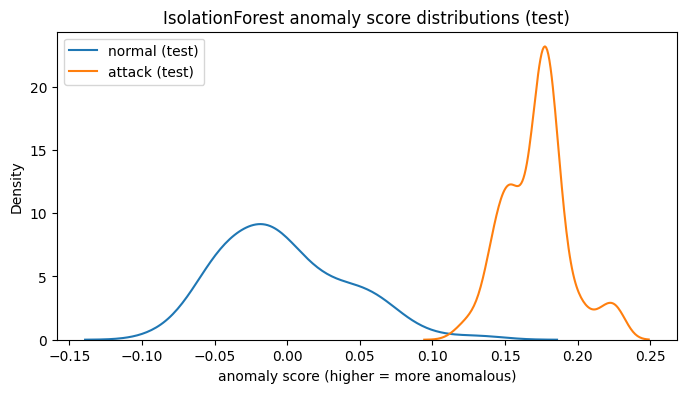

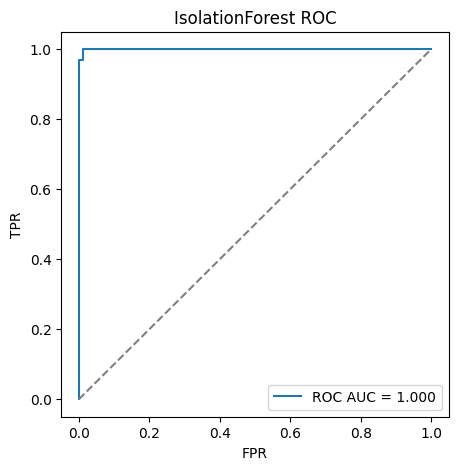


Per-client AUCs:
count: 1 mean: 1.0 median: 1.0 min: 1.0


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, precision_score, recall_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

X_train_full = train_df[num_cols].fillna(0)
X_test_full  = test_df[num_cols].fillna(0)

train_norm = train_df[train_df['anomaly_label'] == 0]
if len(train_norm) < 10:
    raise RuntimeError("Not enough normal samples to train Isolation Forest.")

scaler_if = StandardScaler().fit(train_norm[num_cols].fillna(0))
X_train_if_s = scaler_if.transform(train_norm[num_cols].fillna(0))
X_test_if_s  = scaler_if.transform(X_test_full)


if_model = IsolationForest(
    n_estimators=500,
    max_samples='auto',
    contamination='auto',
    random_state=42,
    n_jobs=-1
)

if_model.fit(X_train_if_s)

# Create the 'models' directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Save the fitted IsolationForest model
joblib.dump(if_model, "models/isolation_forest.pkl")
print("IsolationForest model saved to 'models/isolation_forest.pkl'")

# Save the fitted scaler
joblib.dump(scaler_if, "models/if_scaler.pkl")
print("IsolationForest scaler saved to 'models/if_scaler.pkl'")


scores_raw = if_model.decision_function(X_test_if_s)
scores = -scores_raw
y_true = test_df['anomaly_label'].reset_index(drop=True)

roc = roc_auc_score(y_true, scores)
pr  = average_precision_score(y_true, scores)

print(f"IsolationForest ROC-AUC: {roc:.4f}")
print(f"IsolationForest PR-AUC : {pr:.4f}")


def precision_at_k(y_true, y_scores, k):
    k = max(1, int(k))
    idx = np.argsort(y_scores)[::-1][:k]
    return y_true.iloc[idx].mean()

for pct in [0.01, 0.02, 0.05]:
    k = int(len(y_true) * pct)
    print(f"Precision@{int(pct*100)}% (k={k}):",
          precision_at_k(y_true, pd.Series(scores), k))


normal_scores = scores[y_true == 0]

desired_fpr = 0.01
thr = np.quantile(normal_scores, 1 - desired_fpr)

pred = (scores >= thr).astype(int)

print("\nConfusion matrix (FPR-based threshold):")
print(confusion_matrix(y_true, pred))
print("Precision, Recall:",
      precision_score(y_true, pred),
      recall_score(y_true, pred))

plt.figure(figsize=(8,4))
sns.kdeplot(scores[y_true==0], label='normal (test)', bw_adjust=1.0)
sns.kdeplot(scores[y_true==1], label='attack (test)', bw_adjust=1.0)
plt.title('IsolationForest anomaly score distributions (test)')
plt.xlabel('anomaly score (higher = more anomalous)')
plt.legend()
plt.show()

fpr, tpr, _ = roc_curve(y_true, scores)
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc:.3f}')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('IsolationForest ROC')
plt.legend()
plt.show()

per_client_auc = {}

for client, grp in test_df.reset_index().groupby('user_id'):
    if len(grp) < 5:
        continue
    idxs = grp.index.tolist()
    client_scores = pd.Series(scores).iloc[idxs].values
    client_labels = grp['anomaly_label'].values
    try:
        per_client_auc[client] = roc_auc_score(client_labels, client_scores)
    except Exception:
        per_client_auc[client] = np.nan

vals = [v for v in per_client_auc.values() if not np.isnan(v)]
if vals:
    import statistics
    print("\nPer-client AUCs:")
    print("count:", len(vals),
          "mean:", statistics.mean(vals),
          "median:", statistics.median(vals),
          "min:", min(vals))
else:
    print("Not enough per-client samples for AUC computation.")

if_model_scores = {
    'if_model': if_model,
    'scaler_if': scaler_if,
    'test_scores': scores,
    'test_y': y_true,
    'threshold_used': thr,
    'desired_fpr': desired_fpr
}

attack-generalization stress testing

In [ ]:
print("df_raw columns:")
print(df_raw.columns)

print("\ntrain_df columns:")
print(train_df.columns)

print("\ntest_df columns:")
print(test_df.columns)


df_raw columns:
Index(['timestamp', 'user_id', 'session_id', 'user_role', 'source_ip',
       'region', 'country', 'latitude', 'longitude', 'action', 'status',
       'bytes_sent', 'bytes_received', 'auth_method', 'response_time_ms',
       'anomaly_label', 'ip_is_public', 'asn', 'vpc_id', 'subnet_id',
       'src_port', 'dst_port', 'protocol', 'attack_type', 'attack_stage',
       'attack_id', 'session_label', 'ground_truth', 'event_time', 'event_id',
       'request_id', 'event_name', 'event_source', 'user_agent',
       'principal_type', 'principal_arn'],
      dtype='object')

train_df columns:
Index(['session_id', 'user_id', 'user_role', 'region', 'session_label',
       'anomaly_label', 'start_ts', 'end_ts', 'num_events', 'total_bytes',
       'mean_bytes', 'max_bytes', 'mean_resp', 'std_resp', 'unique_actions',
       'num_failures', 'duration_s'],
      dtype='object')

test_df columns:
Index(['session_id', 'user_id', 'user_role', 'region', 'session_label',
       'anomaly_labe

In [ ]:

session_attack_type = (
    df_raw
    .dropna(subset=['attack_type'])
    .groupby('session_id')['attack_type']
    .agg(lambda x: x.mode().iloc[0])
)


In [ ]:
train_df['attack_type'] = train_df['session_id'].map(session_attack_type)
test_df['attack_type']  = test_df['session_id'].map(session_attack_type)


In [ ]:
print(train_df['attack_type'].value_counts(dropna=False))
print(test_df['attack_type'].value_counts(dropna=False))


attack_type
NaN           720
data_exfil     28
Name: count, dtype: int64
attack_type
data_exfil          224
NaN                  83
brute_force           5
credential_theft      4
privilege_misuse      3
api_abuse             2
Name: count, dtype: int64


In [ ]:
seen_attacks = (
    train_df['attack_type']
    .dropna()
    .unique()
    .tolist()
)

unseen_attacks = (
    test_df['attack_type']
    .dropna()
    .unique()
)

unseen_attacks = [a for a in unseen_attacks if a not in seen_attacks]

print("Seen attacks (train):", seen_attacks)
print("Unseen attacks (test):", unseen_attacks)



Seen attacks (train): ['data_exfil']
Unseen attacks (test): ['credential_theft', 'privilege_misuse', 'brute_force', 'api_abuse']


In [ ]:
scores = -if_model.decision_function(X_test_if_s)
y_true = test_df['anomaly_label']

scores = pd.Series(
    -if_model.decision_function(X_test_if_s),
    index=test_df.index
)


mask = (
    (test_df['anomaly_label'] == 0) |
    (test_df['attack_type'].isin(unseen_attacks))
)

scores_u = scores[mask]
y_u = y_true[mask]


In [ ]:
print("Unseen-attack ROC-AUC:",
      roc_auc_score(y_u, scores_u))

print("Unseen-attack PR-AUC:",
      average_precision_score(y_u, scores_u))


Unseen-attack ROC-AUC: 1.0
Unseen-attack PR-AUC: 1.0


In [ ]:
normal_scores = scores_u[y_u == 0]

desired_fpr = 0.01
thr = np.quantile(normal_scores, 1 - desired_fpr)

pred = (scores_u >= thr).astype(int)

print("Confusion matrix (unseen attacks):")
print(confusion_matrix(y_u, pred))

print("Precision, Recall:",
      precision_score(y_u, pred),
      recall_score(y_u, pred))


Confusion matrix (unseen attacks):
[[82  1]
 [ 0 14]]
Precision, Recall: 0.9333333333333333 1.0


Autoencoder

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, precision_score, recall_score
)


In [ ]:
train_norm = train_df[train_df['anomaly_label'] == 0]

scaler_ae = StandardScaler().fit(train_norm[num_cols])

X_train_ae = scaler_ae.transform(train_norm[num_cols])
X_test_ae  = scaler_ae.transform(test_df[num_cols])

X_train_ae = X_train_ae.astype(np.float32)
X_test_ae  = X_test_ae.astype(np.float32)


In [ ]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 142.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 171.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 215.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 9.0 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [ ]:
def build_autoencoder(input_dim):
    inputs = layers.Input(shape=(input_dim,))

    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(32, activation='relu')(x)
    latent = layers.Dense(16, activation='relu')(x)

    x = layers.Dense(32, activation='relu')(latent)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(input_dim)(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='mse'
    )
    return model


In [ ]:
ae = build_autoencoder(X_train_ae.shape[1])

history = ae.fit(
    X_train_ae,
    X_train_ae,
    epochs=30,
    batch_size=64,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.9519 - val_loss: 0.8826
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8754 - val_loss: 0.8299
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7538 - val_loss: 0.7532
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6551 - val_loss: 0.6243
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5160 - val_loss: 0.4872
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3749 - val_loss: 0.3980
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2877 - val_loss: 0.3336
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2306 - val_loss: 0.2669
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1784 - val_loss: 0.1992
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1359 - val_loss: 0.1703
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1067 - val_loss: 0.1099
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0859 - val_l

In [ ]:
X_test_recon = ae.predict(X_test_ae, verbose=0)

recon_error = np.mean(
    np.square(X_test_ae - X_test_recon),
    axis=1
)

scores = pd.Series(
    recon_error,
    index=test_df.index
)

y_true = test_df['anomaly_label']


In [ ]:
roc = roc_auc_score(y_true, scores)
pr  = average_precision_score(y_true, scores)

print(f"Autoencoder ROC-AUC: {roc:.4f}")
print(f"Autoencoder PR-AUC : {pr:.4f}")


Autoencoder ROC-AUC: 0.9871
Autoencoder PR-AUC : 0.9958


In [ ]:
def precision_at_k(y_true, scores, k):
    idx = np.argsort(scores)[::-1][:k]
    return y_true.iloc[idx].mean()

for pct in [0.01, 0.02, 0.05]:
    k = int(len(y_true) * pct)
    print(f"Precision@{int(pct*100)}%:", precision_at_k(y_true, scores, k))


Precision@1%: 1.0
Precision@2%: 1.0
Precision@5%: 1.0


In [ ]:
normal_scores = scores[y_true == 0]

desired_fpr = 0.01
thr = np.quantile(normal_scores, 1 - desired_fpr)

pred = (scores >= thr).astype(int)

print("Confusion matrix:")
print(confusion_matrix(y_true, pred))

print("Precision, Recall:",
      precision_score(y_true, pred),
      recall_score(y_true, pred))


Confusion matrix:
[[ 82   1]
 [ 18 220]]
Precision, Recall: 0.995475113122172 0.9243697478991597


In [ ]:
seen_attacks = (
    train_df['attack_type']
    .dropna()
    .unique()
    .tolist()
)

unseen_attacks = [
    a for a in test_df['attack_type'].dropna().unique()
    if a not in seen_attacks
]

mask = (
    (test_df['anomaly_label'] == 0) |
    (test_df['attack_type'].isin(unseen_attacks))
)

scores_u = scores[mask]
y_u = y_true[mask]

print("Unseen-attack ROC-AUC:",
      roc_auc_score(y_u, scores_u))

print("Unseen-attack PR-AUC:",
      average_precision_score(y_u, scores_u))


Unseen-attack ROC-AUC: 1.0
Unseen-attack PR-AUC: 1.0


FEDERATED LEARNING

In [ ]:
client_datasets = {}

for client_id, grp in train_df.groupby('user_id'):
    norm = grp[grp['anomaly_label'] == 0]

    if len(norm) < 3:   # <- THIS is the correct threshold
        continue

    Xc = scaler_ae.transform(norm[num_cols]).astype(np.float32)
    client_datasets[client_id] = Xc

print("Number of participating clients:", len(client_datasets))
print("Samples per client:",
      [X.shape[0] for X in client_datasets.values()][:10])


Number of participating clients: 189
Samples per client: [3, 4, 4, 4, 4, 3, 4, 3, 3, 3]


In [ ]:
def build_autoencoder(input_dim):
    inputs = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    latent = tf.keras.layers.Dense(16, activation='relu')(x)

    x = tf.keras.layers.Dense(32, activation='relu')(latent)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(input_dim)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model


In [ ]:
def fedavg(weight_list):
    new_weights = []
    for weights in zip(*weight_list):
        new_weights.append(np.mean(weights, axis=0))
    return new_weights


In [ ]:
NUM_ROUNDS = 4
LOCAL_EPOCHS = 3
BATCH_SIZE = 32


In [ ]:
global_model = build_autoencoder(X_train_ae.shape[1])
global_weights = global_model.get_weights()


In [ ]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')


In [ ]:
for rnd in range(NUM_ROUNDS):
    print(f"\n--- Federated Round {rnd+1} ---")
    client_weights = []

    for client_id, Xc in client_datasets.items():

        local_model = build_autoencoder(X_train_ae.shape[1])
        local_model.set_weights(global_weights)


        local_model.fit(
            Xc, Xc,
            epochs=LOCAL_EPOCHS,
            batch_size=BATCH_SIZE,
            verbose=0
        )


        client_weights.append(local_model.get_weights())


    global_weights = fedavg(client_weights)
    global_model.set_weights(global_weights)

    print(f"Completed round {rnd+1}")



--- Federated Round 1 ---
Completed round 1

--- Federated Round 2 ---
Completed round 2

--- Federated Round 3 ---
Completed round 3

--- Federated Round 4 ---
Completed round 4


In [ ]:
X_test_recon = global_model.predict(X_test_ae, verbose=0)

recon_error = np.mean(
    np.square(X_test_ae - X_test_recon),
    axis=1
)

scores_fl = pd.Series(recon_error, index=test_df.index)
y_true = test_df['anomaly_label']


In [ ]:
print("Federated AE ROC-AUC:",
      roc_auc_score(y_true, scores_fl))

print("Federated AE PR-AUC:",
      average_precision_score(y_true, scores_fl))


Federated AE ROC-AUC: 1.0
Federated AE PR-AUC: 1.0


In [ ]:
normal_scores = scores_fl[y_true == 0]

desired_fpr = 0.01
thr = np.quantile(normal_scores, 1 - desired_fpr)

pred = (scores_fl >= thr).astype(int)

print("Confusion matrix (Federated AE):")
print(confusion_matrix(y_true, pred))

print("Precision, Recall:",
      precision_score(y_true, pred),
      recall_score(y_true, pred))


Confusion matrix (Federated AE):
[[ 82   1]
 [  0 238]]
Precision, Recall: 0.99581589958159 1.0
